# PZT Actuator Model

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

### Layer Material Class

In [105]:
@dataclass
class LayerMaterial:
    thickness: float  # quoted material thickness
    E: np.ndarray  # Young's modulus
    v: float  # poisson's ratio
    density: float

    d31: float = field(default=0)  # piezoelectric constant
    G12: float = field(default=0)  # shear modulus

    # modified constants for piezoelectric material
    p: float = field(init=False)
    Q11: float = field(init=False)
    Q22: float = field(init=False)
    Q12: float = field(init=False)
    Q66: float = field(init=False)
    Q: np.ndarray = field(init=False)

    def __post_init__(self):
        # piezoelectric constant d31 is multiplied by 1+vp because the width is much greater than
        # the thickness, this is the plane strain case (ey = 0) as described by weinberg
        if self.d31 != 0:
            self.d31 = self.d31 * (1 + self.v)  # piezoelectric constant
        
        if self.G12 == 0:
            self.G12 = self.E[0] / (2 * (1 + self.v))  # shear modulus
        
        # modified constants for piezoelectric material
        # noting that although the the plane strain state is
        # occuring on a ply by ply basis while not neccessarily on the whole
        self.p = 1 / (1 - self.v**2 * (self.E[1] / self.E[0]))
        self.Q11 = self.p * self.E[0]
        self.Q22 = self.p * self.E[1]
        self.Q12 = self.p * self.v * self.E[1]
        self.Q66 = self.G12
        self.Q = np.array([[self.Q11, self.Q12, 0], [self.Q12, self.Q22, 0], [0, 0, self.Q66]])

### Actuator Class

In [107]:
class PZTActuator:
    # Initialize actuator with geometric parameters
    def __init__(self, wnom: float, wr: float, l: float, lr: float, pzt_material: LayerMaterial, elastic_material: LayerMaterial):
        self.wnom = wnom                            # actuator width
        self.wr = wr                                # width ratio
        self.l = l                                  # actuator length
        self.lr = lr                                # extension ratio
        self.pzt_material = pzt_material            # piezo material
        self.elastic_material = elastic_material    # elastic layer material
    
    
    def processlayers(self, plyt, oldlayup):
        """
        Processes the layup to account for which layer the neutral axis
        cuts through and adjusts the z-heights relative to the neutral axis.

        INPUTS:
            plyt        -   (n X 1) vector of layer thicknesses
            oldlayup    -   elastic layer layup

        OUTPUTS:
            newz        -   modified z-heights with respect to the neutral axis
            layup       -   modified layup
        """

        print("\nPROCESS LAYERS")
        # for calculations, get midplane level
        zmid = sum(plyt) / 2
        print(f"zmid: {zmid}")

        print(f"plyt: {plyt}")

        # get the heights of each layer
        plyh = np.zeros(len(plyt))
        for i in range(len(plyt)):
            plyh[i] = sum(plyt[0:i+1])
        print(f"plyh: {plyh}")

        # decide which layer the midplane cuts through
        midlayer = min(np.where(plyh > zmid)[0])
        print(f"midlayer: {midlayer}")

        if midlayer == 0:
            newplyt = [zmid, plyh[0] - zmid, plyt[1:len(plyt)]]
        else:
            newplyt = np.array([plyt[0:(midlayer)][0], zmid - plyh[midlayer - 1], 
                                plyh[midlayer] - zmid, plyt[(midlayer + 1):len(plyt)][0]])
            
        print(f"newplyt: {newplyt}")

        # now get z where z(i) is the directed position of the top surface of 
        # layer i with respect to the midlayer
        half_len = len(newplyt) // 2
        z_array = np.array([-1] * half_len + [1] * (len(newplyt) - half_len))
        print(f"z_array: {z_array}")

        newz = z_array * np.array(newplyt)
        print(f"newz: {newz}")

        # now adjust the layup appropriately
        # if the neutral axis cuts through the last layer (piezo)
        if midlayer == len(plyh):
            # keep the layup the same
            new_layup = oldlayup;   
        # if the neutral axis does not cut through the last layer...
        else:
            # neutral axis cuts through the elastic layer
            new_layup = [0, 0] #[oldlayup(1)*[1:midlayer];oldlayup(midlayer);oldlayup(midlayer+1:length(oldlayup))]

        print(f"new_layup: {new_layup}")
    
        return newz, new_layup
    

    def getZN(self, z):
        """
        Returns the individual ply thicknesses for all
        lamina within a laminate

        INPUTS:
            z           -   (n X 1) vector of directed ply coordinates

        OUTPUTS:
            zn1         -   z(n) - z(n-1)
            zn2         -   z(n)^2 - z(n-1)^2
            zn3         -   z(n)^3 - z(n-1)^3
        """

        print("\nGET ZN")
        print(f"z: {z}")

        ztemp = np.hstack([z[z < 0], 0, z[z > 0]])
        print(f"ztemp: {ztemp}")

        zn1 = np.diff(ztemp)
        zn2 = np.diff(ztemp ** 2)
        zn3 = np.diff(ztemp ** 3)
        print(f"zn1: {zn1}")
        print(f"zn2: {zn2}")
        print(f"zn3: {zn3}")

        zn = np.vstack([zn1, zn2, zn3])
        zn = zn.T
        print(f"zn: {zn}")
    
        return zn
    

    def trotate(self, Q, theta):
        """
        Rotates the stiffness matrix Q for a given ply angle theta.

        Parameters:
            Q (numpy.ndarray): 3x3 stiffness matrix.
            theta (float): Ply angle in radians.

        Returns:
            numpy.ndarray: Rotated stiffness matrix Qbar.
        """
        c = np.cos(theta)
        s = np.sin(theta)

        # Transformation matrix
        T = np.array([
            [c**2, s**2, 2*c*s],
            [s**2, c**2, -2*c*s],
            [-c*s, c*s, c**2 - s**2]
        ])

        # Compute the rotated stiffness matrix
        T_inv = np.linalg.inv(T)
        Qbar = T_inv @ Q @ T_inv.T

        return Qbar
    
    
    def getABD(self, layup, Qpiezo, Qelastic, zn):
        """
        Returns the laminate matrices for a given layup with
        plys oriented with the angles in the vector
        laminate.

        INPUTS:
            layup       -   (n-m) X 1 vector of ply angles
            Qelastic    -   elastic layer constants
            Qpiezo      -   piezo layer constants
            zn          -   n X 3 matrix of thickenesses

        OUTPUTS:
            A,B,D       -   laminate matrices
        """

        print("\nGET ABD")

        nelasticlayers = len(layup)
        print(f"zn: {zn}")
        npiezolayers = len(zn) - nelasticlayers

        print(f"nelasticlayers: {nelasticlayers}")
        print(f"npiezolayers: {npiezolayers}")

        A = np.zeros((3,3))
        B = np.zeros((3,3))
        D = np.zeros((3,3))

        # For bimorph actuator
        # include piezo layers first...
        A = Qpiezo * (zn[0, 0] + zn[-1, 0])
        B = Qpiezo * (zn[0, 1] + zn[-1, 1])
        D = Qpiezo * (zn[0, 2] + zn[-1, 2])
            
        # ... then all other layers
        for m in range(nelasticlayers):
            angle = layup[m] * np.pi / 180  # ply angle in radians
            Qbarelastic = self.trotate(Qelastic, angle)
            # A = A + Qbarelastic * zn[m + self.piezoconfig, 0]
            # B = B + Qbarelastic * zn[m + self.piezoconfig, 1]
            # D = D + Qbarelastic * zn[m + self.piezoconfig, 2]
            
            A = A + Qbarelastic * zn[m + 1, 0]
            B = B + Qbarelastic * zn[m + 1, 1]
            D = D + Qbarelastic * zn[m + 1, 2]

        B = B / 2
        D = D / 3
        
        print(f"A: {A}")
        print(f"B: {B}")
        print(f"D: {D}")

        return A, B, D
    
    def piezoelectric(self, V, Qp, zn, d31):
        """
        extracts the thermal forces and moments (per unit
        width) as a function of the voltage (V), the 3 X 3 
        matrix Qp containing the physical properties 
        of the elastic layer, the thicknesses, z, of the n layers, 
        and the coeffiecients of piezoelectric expansion, a 3 X 1
        matrix d31.
        """

        print("\nPIEZOELECTRIC")
        # if there is more than one piezo layer, then the midplane 
        # cuts through the piezo layer and part of it is above and 
        # part below the midplane.
        Np = np.zeros(3)
        Mp = np.zeros(3)

        # Length of zn (number of layers)
        length = zn.shape[0]

        Np = Qp @ np.array([d31, d31, 0]) * V
        Mp = Qp @ np.array([d31, d31, 0]) * V * (abs(zn[length - 1, 1] / zn[length - 1, 0])) / 2

        print(f"Np: {Np}")
        print(f"Mp: {Mp}")

        return Np, Mp
    

    def getG(self):
        """
        Computes the geometric factors Gd and GF for the actuator.

        Returns:
            Gd (float): Geometric factor for displacement.
            GF (float): Geometric factor for force.
        """
        print("\nGET G")
        # Define symbolic variable
        # temp = symbols('temp')

        # Compute terms
        ga = 6 * (self.wr - 1) * (-3 - 2 * self.lr + 2 * self.wr + 2 * self.lr * self.wr)
        gb = 3 * (self.wr - 2) * (-2 - 2 * self.lr + self.wr + 2 * self.lr * self.wr) * np.log((2 - self.wr) / self.wr)
        gc = 8 * (1 - self.wr)**3
        gd = 6 * (self.wr - 1) * (3 + 4 * self.lr - 2 * self.wr - 4 * self.lr * self.wr)
        ge = 3 * (-2 - 2 * self.lr + self.wr + 2 * self.lr * self.wr)**2 * np.log((2 - self.wr) / self.wr)

        print(f"ga: {ga}")
        print(f"gb: {gb}")
        print(f"gc: {gc}")
        print(f"gd: {gd}")
        print(f"ge: {ge}")

        # Compute Glext and Gl
        Glext = (gd + ge) / gc
        Gl = (ga + gb) / gc

        print(f"Glext: {Glext}")
        print(f"Gl: {Gl}")  

        # Compute Gd and GF
        Gd = (1 + 2 * self.lr)
        GF = Gd / Glext

        print(f"Gd: {Gd}")
        print(f"GF: {GF}")

        G = np.array([Gd, GF])
        print(f"G: {G}")

        return G

        
    def energy(self, Qpiezo, Qelastic, V, d31, layup):
        """
        For given elastic layer geometries and properties this function
        calculates the displacement, blocked force, and stiffness for either
        unimorph or bimorph cantilever actuators with arbitrary elastic layer layups.

        INPUTS:
            width       -   (2 X 1) vector of the actuator nominal width and width ratio
            len         -   (2 X 1) vector of the actuator length and the length ratio
            thickness   -   (2 X 1) vector of piezo thickness and elastic layer thickness
            Qpiezo      -   (3 X 3) vector of piezo material elastic constants
            Qelastic    -   (3 X 3) vector of elastic layer material elastic constants
            V           -   drive voltage
            d31         -   transverse piezoelectric constant
            layup       -   (n X 1) elastic layer layup angles (in degrees)

        OUTPUTS:
            delta       -   free displacement
            Fb          -   blocked force
            k           -   stiffness
        """

        print("\nENERGY")

        # for now, just give ply thicknesses and calculate the stiffnesses, etc...or make this a
        # function and call it from a loop to return the stiffnesses as a function of single ply
        # thickness.

        tpzt = self.pzt_material.thickness  # piezo layer thickness
        telastic = self.elastic_material.thickness  # elastic layer thickness

        # get actuator ply thicknesses
        plyt = np.hstack([tpzt, telastic * np.ones(len(layup)), tpzt])

        newz, layup = self.processlayers(plyt, layup)

        # now get z(n)-z(n-1)...
        zn = self.getZN(newz)

        # now get A,B,C,D for the sglass and the UHM actuator:
        A, B, D = self.getABD(layup, Qpiezo, Qelastic, zn)

        # get piezoelectric forces and moments:
        # npiezolayers = len(newz) - len(layup) - self.piezoconfig
        # Np, Mp = self.piezoelectric(V, Qpiezo, zn, d31, npiezolayers)
        Np, Mp = self.piezoelectric(V, Qpiezo, zn, d31)

        # now get mid plane strains and curvature
        stiffness = np.block([[A, B], [B, D]])
        print(f"stiffness: {stiffness}")
        C = np.linalg.inv(stiffness)
        print(f"C: {C}")
        P = (
            C[3, 0] * Np[0] +
            C[3, 1] * Np[1] +
            C[3, 3] * Mp[0] +
            C[3, 4] * Mp[1]
        )
        print(f"P: {P}")

        G = self.getG()

        # Extract actuator displacement from radius of curvature (peak-to-peak)
        delta = -(P * self.l**2 / 2) * G[0]
        delta = delta * 2  # multiply by two for peak-to-peak blocked force

        # Compute the blocked force (peak-to-peak)
        Fb = -(3 * P * self.wnom) / (2 * self.l * C[3, 3]) * G[1]
        Fb = Fb * 2  # multiply by two for peak-to-peak blocked force

        # Compute stiffness
        k = abs(Fb / delta)

        print(f"delta: {delta}")
        print(f"Fb: {Fb}")
        print(f"k: {k}")

        return delta, Fb, k

### Layer Material Properties

In [108]:
# PZT-5H Polycrystalline Piezo
PZT = LayerMaterial(thickness = 127e-6,
                    E = np.array([62e9, 62e9, 0]),
                    v = 0.31,
                    density = 7.87e3,
                    d31 = -320e-12)

# PZN-PT Single Crystal Piezo
PZNPT = LayerMaterial(thickness = 100e-6,
                      E = np.array([4e-6, 4e-6, 0]),
                      v = 0.26,
                      density = 8e3,
                      d31 = -950e-12)

# Ultra-High-Modulus Carbon Fiber
UHMCF = LayerMaterial(thickness = 40e-6,
                      E =  np.array([260e9, 7e9, 0]),
                      v = 0.33,
                      density = 1.5e3,
                      G12 = 5e9)

# Steel
Steel = LayerMaterial(thickness = 127e-6,
                      E =  np.array([190e9, 190e9, 0]),
                      v = 0.30,
                      density = 8e3)

# Silicon
Silicon = LayerMaterial(thickness = 127e-6,
                      E =  np.array([185e9, 185e9, 0]),
                      v = 0.25,
                      density = 2.33e3)

# S2-Glass Composite
SGlass = LayerMaterial(thickness = 127e-6,
                      E =  np.array([55e9, 14e9, 0]),
                      v = 0.33,
                      density = 1.78e3,
                      G12 = 5e9)

### RoboBee Actuator

In [109]:
# RoboBee actuator
RoboBee_actuator = PZTActuator(wnom = 1.125e-3,
                               wr = 1.5,
                               l = 9e-3,
                               lr = 3/9,
                               pzt_material= PZT,
                               elastic_material = UHMCF)

# adjusted stiffness matrices
Qpiezo = PZT.Q
d31 = PZT.d31
Qelastic = UHMCF.Q

V = 200  # Drive voltage
layup = [0]  # actuator elastic layer layup

RoboBee_actuator.energy(Qpiezo, Qelastic, V, d31, layup)



ENERGY

PROCESS LAYERS
zmid: 0.000147
plyt: [1.27e-04 4.00e-05 1.27e-04]
plyh: [0.000127 0.000167 0.000294]
midlayer: 1
newplyt: [1.27e-04 2.00e-05 2.00e-05 1.27e-04]
z_array: [-1 -1  1  1]
newz: [-1.27e-04 -2.00e-05  2.00e-05  1.27e-04]
new_layup: [0, 0]

GET ZN
z: [-1.27e-04 -2.00e-05  2.00e-05  1.27e-04]
ztemp: [-1.27e-04 -2.00e-05  0.00e+00  2.00e-05  1.27e-04]
zn1: [1.07e-04 2.00e-05 2.00e-05 1.07e-04]
zn2: [-1.5729e-08 -4.0000e-10  4.0000e-10  1.5729e-08]
zn3: [2.040383e-12 8.000000e-15 8.000000e-15 2.040383e-12]
zn: [[ 1.070000e-04 -1.572900e-08  2.040383e-12]
 [ 2.000000e-05 -4.000000e-10  8.000000e-15]
 [ 2.000000e-05  4.000000e-10  8.000000e-15]
 [ 1.070000e-04  1.572900e-08  2.040383e-12]]

GET ABD
zn: [[ 1.070000e-04 -1.572900e-08  2.040383e-12]
 [ 2.000000e-05 -4.000000e-10  8.000000e-15]
 [ 2.000000e-05  4.000000e-10  8.000000e-15]
 [ 1.070000e-04  1.572900e-08  2.040383e-12]]
nelasticlayers: 2
npiezolayers: 2
A: [[25109196.55411149  4643042.32253293        0.        ]
 

(np.float64(0.0006016779920475014),
 np.float64(0.11416600444206894),
 np.float64(189.7460202151714))

### HAMR Actuator

In [113]:
# HAMR actuator
HAMR_actuator = PZTActuator(wnom = 3.5e-3,
                            wr = 1.5,
                            l = 9.2e-3,
                            lr = 1/9.2,
                            pzt_material= PZT,
                            elastic_material = UHMCF)

# adjusted stiffness matrices
Qpiezo = PZT.Q
d31 = PZT.d31
Qelastic = UHMCF.Q

V = 200  # Drive voltage
layup = [0]  # actuator elastic layer layup

HAMR_actuator.energy(Qpiezo, Qelastic, V, d31, layup)



ENERGY

PROCESS LAYERS
zmid: 0.000147
plyt: [1.27e-04 4.00e-05 1.27e-04]
plyh: [0.000127 0.000167 0.000294]
midlayer: 1
newplyt: [1.27e-04 2.00e-05 2.00e-05 1.27e-04]
z_array: [-1 -1  1  1]
newz: [-1.27e-04 -2.00e-05  2.00e-05  1.27e-04]
new_layup: [0, 0]

GET ZN
z: [-1.27e-04 -2.00e-05  2.00e-05  1.27e-04]
ztemp: [-1.27e-04 -2.00e-05  0.00e+00  2.00e-05  1.27e-04]
zn1: [1.07e-04 2.00e-05 2.00e-05 1.07e-04]
zn2: [-1.5729e-08 -4.0000e-10  4.0000e-10  1.5729e-08]
zn3: [2.040383e-12 8.000000e-15 8.000000e-15 2.040383e-12]
zn: [[ 1.070000e-04 -1.572900e-08  2.040383e-12]
 [ 2.000000e-05 -4.000000e-10  8.000000e-15]
 [ 2.000000e-05  4.000000e-10  8.000000e-15]
 [ 1.070000e-04  1.572900e-08  2.040383e-12]]

GET ABD
zn: [[ 1.070000e-04 -1.572900e-08  2.040383e-12]
 [ 2.000000e-05 -4.000000e-10  8.000000e-15]
 [ 2.000000e-05  4.000000e-10  8.000000e-15]
 [ 1.070000e-04  1.572900e-08  2.040383e-12]]
nelasticlayers: 2
npiezolayers: 2
A: [[25109196.55411149  4643042.32253293        0.        ]
 

(np.float64(0.0004592362985227745),
 np.float64(0.4588677906511685),
 np.float64(999.1975637100304))

In [111]:

# drive parameters
roomtemp = 20
curetemp = 120
V = 300

# analysis of s-glass, UHM, silicon, and steel 
t = 1e-6:2e-6:2*thickness.PZT
piezomass = l * wnom * tp * densityp * (1 + piezoconfig)

[Gd, GF] = getG(wr, lr)

G = [Gd,GF];

for i = 1:length(t),
    % mechanical energy
    [delta.UHM(i),Fb.UHM(i),k.UHM(i)] = energy(w,lentotal,[tp t(i)],Qp,QUHM,V,d31,layup,G);
    [delta.SGlass(i),Fb.SGlass(i),k.SGlass(i)] = energy(w,lentotal,[tp t(i)],Qp,Qs,V,d31,layup,G);
    [delta.steel(i),Fb.steel(i),k.steel(i)] = energy(w,lentotal,[tp t(i)],Qp,Qst,V,d31,layup,G);
    [delta.silicon(i),Fb.silicon(i),k.silicon(i)] = energy(w,lentotal,[tp t(i)],Qp,Qsi,V,d31,layup,G);
    % mass:
    % extension mass (assuming extension is reinforced with 120um of sglass)...
    % extension reinforcement is slightly wider than wnom*(2-wr)
    wcorrect = 1.5;
    mass_UHM_ext = l*lr*wnom*(2-wr)*t(i)*density.UHM + 240e-6*wnom*(2-wr)*l*lr*density.SGlass*wcorrect;
    mass_s_ext = l*lr*wnom*(2-wr)*t(i)*density.SGlass + 240e-6*wnom*(2-wr)*l*lr*density.SGlass*wcorrect;
    mass_st_ext = l*lr*wnom*(2-wr)*t(i)*density.steel + 240e-6*wnom*(2-wr)*l*lr*density.SGlass*wcorrect;
    mass_si_ext = l*lr*wnom*(2-wr)*t(i)*density.silicon + 240e-6*wnom*(2-wr)*l*lr*density.SGlass*wcorrect;
    % total mass:
    mass.UHM(i) = l*wnom*t(i)*density.UHM + piezomass + mass_UHM_ext;
    mass.SGlass(i) = l*wnom*t(i)*density.SGlass + piezomass + mass_s_ext;
    mass.steel(i) = l*wnom*t(i)*density.steel + piezomass + mass_st_ext;
    mass.silicon(i) = l*wnom*t(i)*density.silicon + piezomass + mass_si_ext;
end

%create a title for each plot which describes the actuator
if piezoconfig,
    fig_title = strcat('Bimorph',sprintf(', l = %g(mm), l_r = %g , w_{nom} = %g(mm), w_r = %g, V = %g',...
        l*1e3,lr,wnom*1e3,wr,V));
else
    fig_title = strcat('Unimorph',sprintf(', l = %g(mm), l_r = %g , w_{nom} = %g(mm), w_r = %g, V = %g',...
        l*1e3,lr,wnom*1e3,wr,V));
end

SyntaxError: invalid syntax (1998158595.py, line 7)

### Plot Displacement

In [ ]:
set(axes,'Fontsize',14);
plot(t*1e6, delta.UHM*1e6,'r-',... 
    t*1e6, delta.SGlass*1e6,'k:',...
    t*1e6, delta.steel*1e6,'m-.',...
    t*1e6, delta.silicon*1e6,'b--', 'LineWidth',3);
ylabel('Tip Displacement (\mum)','Fontsize',20);
xlabel('Passive Layer Thickness (\mum)','Fontsize',20);
title(fig_title,'Fontsize',18);
%legend('UHM M60J','S2 glass','Steel','Si');
grid on
%print
name = strcat(piezotype,'delta.jpg');
%print(1, '-djpeg', name);

### Plot Blocked Force

In [ ]:
set(axes,'Fontsize',14)
plot(t*1e6,Fb.UHM*1e3,'r-',...
    t*1e6,Fb.SGlass*1e3,'k:',...
    t*1e6,Fb.steel*1e3,'m-.',...
    t*1e6,Fb.silicon*1e3,'b--', 'LineWidth',3)
xlabel('Passive Layer Thickness (\mum)','Fontsize',20)
ylabel('Blocked Force (mN)','Fontsize',20)
title(fig_title,'Fontsize',18)
%    legend('UHM M60J','S2 glass','Steel','Si')
grid on
name = strcat(piezotype,'Fb.jpg')

### Plot Stiffness

In [ ]:
set(axes,'Fontsize',14)
plot(t*1e6,k.UHM,'r-',...
    t*1e6, k.SGlass, 'k:',...
    t*1e6,k.steel,'m-.',...
    t*1e6,k.silicon,'b--', 'LineWidth',3)
xlabel('Passive Layer Thickness (\mum)','Fontsize',20)
ylabel('Stiffness (Nm^-^1)','Fontsize',20)
title(fig_title,'Fontsize',18)
% legend('UHM M60J','S2 glass','Steel','Si')
grid on
name = strcat(piezotype,'stiff.jpg')

### Plot Energy

In [ ]:
set(axes,'Fontsize',14);
plot(t*1e6,delta.UHM.*Fb.UHM/2*1e6,'r-',...
    t*1e6,delta.SGlass.*Fb.SGLass/2*1e6,'k:',...
    t*1e6,delta.steel.*Fb.steel/2*1e6,'m-.',...
    t*1e6,delta.silicon.*Fb.silicon/2*1e6,'b--', 'LineWidth',3);
xlabel('Passive Layer Thickness (\mum)','Fontsize',20);
ylabel('Energy (\muJ)','Fontsize',20);
title(fig_title,'Fontsize',18);
legend('UHM M60J','S2 glass','Steel','Si');
grid on
%print
name = strcat(piezotype,'energy.jpg');
%print(4, '-djpeg', name);


### Plot Energy Density

In [ ]:
set(axes,'Fontsize',14);
plot(t/thickness.PZT,(delta.UHM.*Fb.UHM/2)./mass.UHM,'r-',...
    t/thickness.PZT,(delta.SGlass.*Fb.SGlass/2)./mass.SGlass,'k:',...
    t/thickness.PZT,(delta.steel.*Fb.steel/2)./mass.steel,'m-.',...
    t/thickness.PZT,(delta.silicon.*Fb.silicon/2)./mass.silicon,'b--', 'LineWidth',3);
xlabel('Passive Layer Thickness Ratio (t_r)','Fontsize',20);
ylabel('Energy Density(J/Kg)','Fontsize',20);
title(fig_title,'Fontsize',18);
%  legend('UHM M60J','S2 glass','Steel','Si');
grid on
for i = 1:20:length(t),
    text(t(i)/thickness.PZT,(delta.UHM(i)*Fb.UHM(i)/2)/mass.UHM(i),...
        sprintf('%gmg',round(mass.UHM(i)*1e6*100)/100),'Fontsize',13);
end

%print
name = strcat(piezotype,'density.jpg');
%print(5, '-djpeg', name);

### Plot Extension Ratio

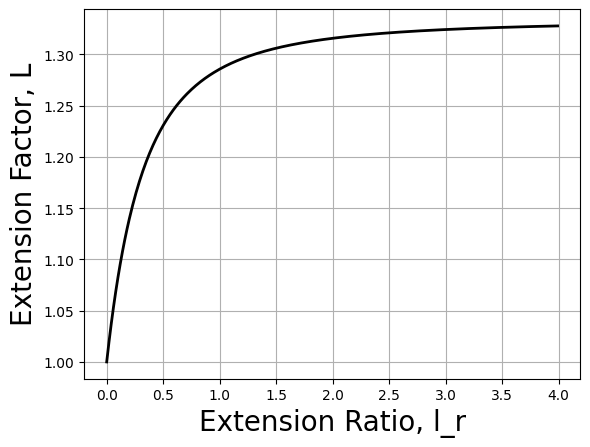

In [ ]:
lr = np.arange(0,4, 0.01)
L = (1 + 2 * lr)**2 / (1 + 3 * lr + 3 * lr**2);  # Eq. (38)

plt.plot(lr, L, 'k', linewidth=2)
plt.xlabel('Extension Ratio, l_r', fontsize=20)
plt.ylabel('Extension Factor, L', fontsize=20)
plt.grid()

### Plot Width Ratio

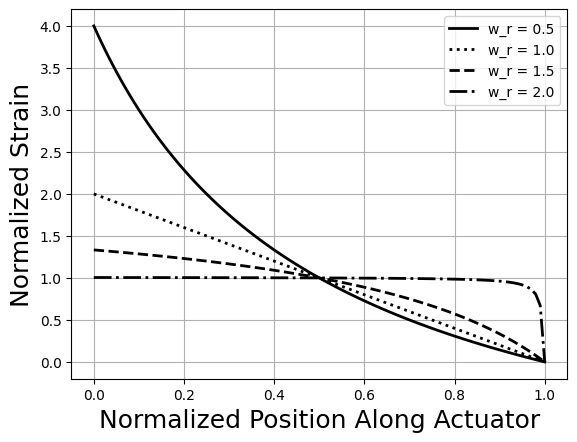

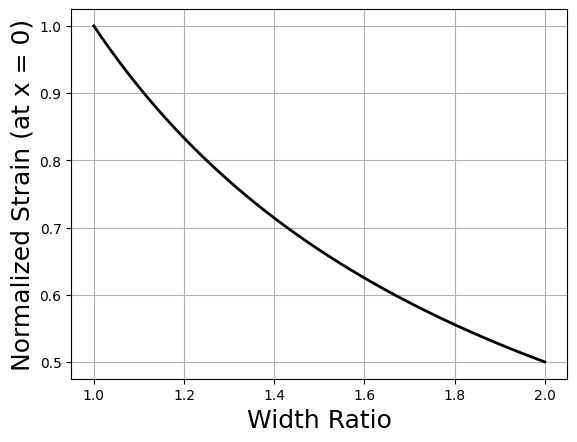

In [115]:
# Constants
E = 200e9
x = np.linspace(0, 10e-3, int(10e-3 / 1e-4) + 1)
F = 100e-3
l = 10e-3
h = 200e-6
wnom = 1e-3

# For straight actuator
wr = 1
w = wnom * (2 * (1 - wr) * x / l + wr)
I = w * h**3 / 12
M = F * (l - x)
epsilon_s = M / E / I * (h / 2)

# For tapered actuator 1
wr = 0.5
w = wnom * (2 * (1 - wr) * x / l + wr)
I = w * h**3 / 12
M = F * (l - x)
epsilon_t1 = M / E / I * (h / 2)

# For tapered actuator 2
wr = 1.5
w = wnom * (2 * (1 - wr) * x / l + wr)
I = w * h**3 / 12
M = F * (l - x)
epsilon_t2 = M / E / I * (h / 2)

# For tapered actuator 3
wr = 1.99
w = wnom * (2 * (1 - wr) * x / l + wr)
I = w * h**3 / 12
M = F * (l - x)
epsilon_t3 = M / E / I * (h / 2)

# Normalize strains
midstrain = np.median(epsilon_t2)
epsilon_t3 /= midstrain
epsilon_t2 /= midstrain
epsilon_t1 /= midstrain
epsilon_s /= midstrain

# Plot normalized strain along actuator
plt.figure(1)
plt.plot(x / l, epsilon_t1, '-k', linewidth=2, label='w_r = 0.5')
plt.plot(x / l, epsilon_s, ':k', linewidth=2, label='w_r = 1.0')
plt.plot(x / l, epsilon_t2, '--k', linewidth=2, label='w_r = 1.5')
plt.plot(x / l, epsilon_t3, '-.k', linewidth=2, label='w_r = 2.0')
plt.ylabel('Normalized Strain', fontsize=18)
plt.xlabel('Normalized Position Along Actuator', fontsize=18)
plt.legend()
plt.grid()
plt.show()

# Plot normalized strain at x = 0 vs width ratio
wr = np.arange(1, 2.01, 0.01)
epsilon = 1 / wr
plt.figure(2)
plt.plot(wr, epsilon / np.max(epsilon), 'k', linewidth=2)
plt.ylabel('Normalized Strain (at x = 0)', fontsize=18)
plt.xlabel('Width Ratio', fontsize=18)
plt.grid()
plt.show()

In [ ]:
def wratio(ratio):
    """
    function Widthfactor = wratio(ratio)

    This function takes the width ratio, ratio, and 
    calculates the width factor, Widthfactor, by looking
    up within the data set previously determined

    inputs:
        ratio           the width ratio, 0<ratio<2
    outputs:
        Widthfactor     the corresponding width factor

    """

    % if the width ratio is out of range, give an error
    if (ratio>2)||(ratio<0)
        disp('error in width ratio range');
        return
    end

    % load the previously determined width factor data
    temp = load('width');
    W = temp.W;
    wr = temp.wr;

    % for the given width ratio, find what the width factor is
    % first determine which value of 'wr' is closest to 'ratio'
    for n = 1:length(wr),
        if ratio > wr(n),
            index = n;
        end
    end

    Widthfactor = W(index);


In [ ]:
clear
close all

load widthext

wrmax = 2;
lrmax = 4;

wr = 0:wrmax/(size(Gnew,2)-1):wrmax;
lr = 0:lrmax/(size(Gnew,1)-1):lrmax;

[WR,LR] = meshgrid(wr,lr);
figure(1);
    set(axes,'Fontsize',14);
    [c,h] = contourf(WR,LR,Gnew,[0,0.2,0.4,0.6,0.8,1.0,1.2,1.3,1.33]);
    clabel(c,h,'fontsize',14);
    colormap('gray');
    
    xlabel('w_r','Fontsize',18);
    ylabel('l_r','Fontsize',18);
    zlabel('G_U','Fontsize',18);

figure(2);
    set(axes,'Fontsize',14);
    mesh(WR,LR,Gnew);
    colormap('gray');
    
    xlabel('w_r','Fontsize',18);
    ylabel('l_r','Fontsize',18);
    zlabel('G_U','Fontsize',18);